In [1]:
from mgo import mgo

from IPython.display import display, Markdown
import folium
import matplotlib.pyplot as plt

In [2]:
file_dir = 'mgo/uploads'
village = 'Nakiu'

min_area = 70 # exclude any buildings with area (in m2) below this value
max_length = 10000 # The furthest a single building can be (in total) from the PV point

cost_wire = 25 # per metre
cost_connection = 150 # per node
opex_ratio = 0.02 # % of the above per year
years = 20 # years over which to amortize (and maintain)
tariff = 0.25  # USD/kWh
demand = 6 # 6kWh/person/month = MTF Tier 2
gen_cost = 7000  # USD/kW
discount_rate = 0.08

In [3]:
buildings = mgo.load_buildings(village=village,
                               file_dir=file_dir,
                               min_area=min_area)

x_mean = buildings.geometry.centroid.x.mean()
y_mean = buildings.geometry.centroid.y.mean()
village_map = folium.Map([y_mean, x_mean], zoom_start=15, control_scale=True)

popup_html = '<h2>Latitude: " + lat + "</h2><h2>Longitude: " + lng + "</h2><h3>Copy these values into the variables below.</h3>'
folium.ClickForMarker(popup=popup_html).add_to(village_map)
display(Markdown('### Please click on the desired location for the PV point.'))
display(Markdown('### Then click on the marker that appears and copy the values in below (with all decimals values!).'))
display(village_map)

Skipping field relations: invalid type 5


### Please click on the desired location for the PV point.

### Then click on the marker that appears and copy the values in below (with all decimals values!).

In [4]:
get_lat = -9.6266
gen_lng = 39.1824

### A small graph is shown below, with the PV point in green

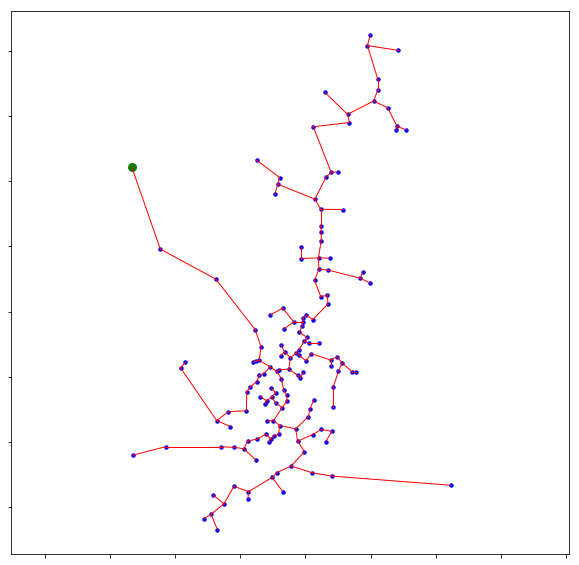

In [5]:
network, nodes = mgo.create_network(buildings,
                                    gen_lat=get_lat,
                                    gen_lng=gen_lng)

xs = [n[1] for n in network]
ys = [n[2] for n in network]
xe = [n[3] for n in network]
ye = [n[4] for n in network]

fig = plt.figure(figsize=(10, 10))
plt.scatter([n[1] for n in nodes[1:]], [n[2] for n in nodes[1:]], s=20, lw=0, c='blue')
plt.scatter(nodes[0][1], nodes[0][2], s=80, lw=0, c='green')
plt.plot([xs, xe], [ys, ye], c='red', lw=1)
display(Markdown('### A small graph is shown below, with the PV point in green'))

fig.axes[0].tick_params(labelbottom=False, labelleft=False)
plt.axis('equal')
plt.show()

In [6]:
results, network, nodes = mgo.run_model(network, nodes,
                                        demand=demand,
                                        tariff=tariff,
                                        gen_cost=gen_cost,
                                        cost_wire=cost_wire,
                                        cost_connection=cost_connection,
                                        opex_ratio=opex_ratio,
                                        years=years,
                                        discount_rate=discount_rate)

display(Markdown(f'Total houses connected: {results["connected"]} out of {len(nodes)-1}'))
display(Markdown(f'Generator installation size: {results["gen_size"]:.0f} kW'))
display(Markdown(f'Total length of lines is {results["length"]:.0f}m'))
display(Markdown(f'CAPEX: ${results["capex"]:.0f}'))
display(Markdown(f'Annual OPEX: ${results["opex"]:.0f}'))
display(Markdown(f'Annual Income: ${results["income"]:.0f}'))
display(Markdown(f'**NPV over {years} years is ${results["npv"]:.0f}**'))

Total houses connected: 141 out of 150

Generator installation size: 110 kW

Total length of lines is 5683m

CAPEX: $933568

Annual OPEX: $18671

Annual Income: $39617

**NPV over 20 years is $-732413**

In [7]:
network_gdf, buildings_gdf = mgo.network_to_spatial(buildings, network, nodes)

village_map = folium.Map([y_mean, x_mean], zoom_start=16, control_scale=True)

folium.GeoJson(network_gdf).add_to(village_map)

icon = folium.Icon(icon='bolt', color='green', prefix='fa')
folium.Marker([get_lat, gen_lng], icon=icon, popup='PV plant location').add_to(village_map)

def highlight_function(feature):
    return {
        'fillColor': '#b2e2e2',
        'fillOpacity': 0.5,
        'color': 'black',
        'weight': 3,
    }

styles = []
max_area = buildings_gdf['area'].max()
for index, row in buildings_gdf.iterrows():
    if row['area'] > max_area*0.8: fill_color = '#006d2c'
    elif row['area'] > max_area*0.6: fill_color = '#2ca25f'
    elif row['area'] > max_area*0.4: fill_color = '#66c2a4'
    elif row['area'] > max_area*0.2: fill_color = '#b2e2e2'
    else: fill_color = '#edf8fb'
    styles.append({'fillColor': fill_color, 'weight': 1, 'color': 'black', 'fillOpacity': 1})
    
buildings_gdf['style'] = styles
folium.GeoJson(buildings_gdf, highlight_function=highlight_function).add_to(village_map)

display(village_map)

In [8]:
len(buildings), len(buildings_gdf)

(150, 141)

In [9]:
buildings_gdf

,type,id,tags,meta,geometry,area,index,X,Y,marg_dist,tot_dist,connected,style
1,way,543041768,{'building': 'yes'},{},"POLYGON ((39.1904398 -9.625552500000355, 39.19...",234.564190,2,1464108,-1144842,28.792360,2125.881186,1,"{'fillColor': '#66c2a4', 'weight': 1, 'color':..."
2,way,543041770,{'building': 'yes'},{},"POLYGON ((39.1901281 -9.62556700000016, 39.190...",250.245536,3,1464077,-1144843,11.704700,2108.793525,1,"{'fillColor': '#2ca25f', 'weight': 1, 'color':..."
3,way,543041775,{'building': 'yes'},{},"POLYGON ((39.1887618 -9.625144900000011, 39.18...",127.014864,4,1463929,-1144795,25.709920,1895.387391,1,"{'fillColor': '#b2e2e2', 'weight': 1, 'color':..."
4,way,543041777,{'building': 'yes'},{},"POLYGON ((39.1894811 -9.624799500000131, 39.18...",247.794520,5,1464009,-1144754,89.894382,1985.281773,1,"{'fillColor': '#2ca25f', 'weight': 1, 'color':..."
5,way,543041782,{'building': 'yes'},{},"POLYGON ((39.1896567 -9.624462300000044, 39.18...",239.726859,6,1464022,-1144719,37.336309,2022.618083,1,"{'fillColor': '#66c2a4', 'weight': 1, 'color':..."
6,way,543041783,{'building': 'yes'},{},"POLYGON ((39.189641 -9.624392399999982, 39.189...",264.799264,7,1464022,-1144688,31.000000,2053.618083,1,"{'fillColor': '#2ca25f', 'weight': 1, 'color':..."
7,way,543041785,{'building': 'yes'},{},"POLYGON ((39.190197 -9.623478100000101, 39.190...",262.447767,8,1464085,-1144599,96.176920,2258.606767,1,"{'fillColor': '#2ca25f', 'weight': 1, 'color':..."
8,way,543041789,{'building': 'yes'},{},"POLYGON ((39.189415 -9.623191799999955, 39.189...",80.418789,9,1463998,-1144553,32.015621,2194.445468,1,"{'fillColor': '#edf8fb', 'weight': 1, 'color':..."
9,way,543041794,{'building': 'yes'},{},"POLYGON ((39.1893828 -9.623356299999898, 39.18...",71.573659,10,1463990,-1144584,108.811764,2162.429847,1,"{'fillColor': '#edf8fb', 'weight': 1, 'color':..."
10,way,543044727,{'building': 'yes'},{},"POLYGON ((39.1882158 -9.626891599999935, 39.18...",86.439146,11,1463863,-1144987,76.026311,1586.242421,1,"{'fillColor': '#b2e2e2', 'weight': 1, 'color':..."
